# **Analyse Quantitative des Risques d'un Portefeuille : Vue d'Ensemble**

## **Introduction**

Cette étude présente une analyse approfondie des risques d'un portefeuille de 100 000 USD composé de 5 actions américaines sur la période 2017-2025.

L'objectif était d'implémenter et comparer différentes méthodologies de mesure du risque pour illustrer leurs forces, faiblesses et divergences.

### **Le Portefeuille Étudié**

- **NVDA** (25%) et **PYPL** (25%) : Secteur technologique

- **BAC** (20%) et **JPM** (10%) : Secteur financier

- **KO** (20%) : Consommation défensive

**Données** :
    - 2 133 observations journalières | **Benchmark** : S&P 500

---

## **Méthodologies Implémentées**

### **1. Modélisation de la Volatilité**

- **Approche naïve** :
    - σ × √252 = 26.30% annuel
- **Modèle GARCH(1,1)** :
    - Capture la volatilité conditionnelle = 23.69% annuel
- **Résultat** :
    - GARCH réduit l'estimation de volatilité de 10%

### **2. Métriques de Performance Ajustée au Risque**

- **Beta** :
    - 1.247 (25% plus volatil que le marché)
- **Ratio de Sharpe** :
    - 0.898 (avec GARCH)
- **Alpha de Jensen** :
    - 8.9% de surperformance annuelle

### **3. Mesures de Risque Extrême (VaR)**

Trois approches pour répondre à :

*"Quelle perte maximale avec 95% de confiance ?"*

- **VaR Historique** :
    - 30.38% annuel (basée sur les crises réelles)
- **VaR Paramétrique** :
    - 41.56% annuel (assume normalité)
- **VaR Monte Carlo** :
    - 14.42% annuel (simulation "temps normal")

### **4. Analyse des Drawdowns**

- **Maximum drawdown observé** :
    - -44.32%

- **Période** :
    - Nov 2021 - Oct 2022 (337 jours)

---

## **Résultats Clés**

### **Performance vs Risque**

| Métrique | Valeur | Insight |
|----------|---------|----------|
| Rendement annualisé | 26.26% | Performance exceptionnelle |
| Volatilité (GARCH) | 23.69% | Risque élevé mais maîtrisé |
| Sharpe Ratio | 0.898 | Performance ajustée au risque correcte |
| Perte maximale | -44.32% | Test de résistance psychologique |

### **L'Importance de l'Incertitude**

Le bootstrap (1 000 simulations) révèle des incertitudes massives :

- **Beta** :
    - 1.247 ± 6.4% ✓ (très fiable)

- **Sharpe** :
    - 0.833 ± 164% ⚠️ (très incertain)

- **Alpha** :
    - 0.089 ± 183% ⚠️ (extrêmement incertain)

### **Analyse par Régime de Marché**

| Période | Contexte | Rendement | Volatilité |
|---------|----------|-----------|------------|
| 2017-2019 | Bull Market | +31.4% | 19.8% |
| 2020 | COVID Crisis | +65.3% | 42.4% |
| 2022 | Bear Market | -29.9% | 35.5% |
| 2023-2025 | Normalisation | +47.9% | 22.0% |

---

## **Insights Principaux**

### **1. La Divergence des Modèles VaR**

- **VaR Historique (30%)** :
-
    - Inclut les crises réelles (COVID, 2022)
        -
- **VaR Monte Carlo (14%)** :
-
    - Assume des conditions normales
        -
- **Leçon** :
-
    - Les deux sont "corrects" selon le contexte d'utilisation

### **2. Violations des Hypothèses Classiques**

- ❌ **Non-normalité** :
-
    - Queues épaisses (kurtosis = 8.81)
        -
- ❌ **Autocorrélation** :
-
    - Volatilité clustering détectée
        -
- ✓ **Solution** :
-
    - GARCH améliore significativement les estimations

### **3. L'Illusion de Précision**

Un Sharpe de 0.833 avec un intervalle [0.15, 1.52] illustre que :
    - La "vraie" valeur peut varier du simple au décuple
    - Les ratios sont extrêmement sensibles aux périodes extrêmes
    - L'incertitude est une caractéristique, pas un défaut

---

## **Conclusions Pratiques**

### **Pour la Gestion des Risques**

1. **Privilégier la VaR historique** (30%) pour le dimensionnement du capital
2. **Utiliser GARCH** pour le monitoring quotidien de la volatilité
3. **Se préparer psychologiquement** à des pertes temporaires de 40%+

### **Pour l'Évaluation de Performance**

1. **Le Beta est fiable** (±6%) pour les décisions d'allocation
2. **Les ratios de Sharpe sont trompeurs** sans intervalles de confiance
3. **L'analyse par régime** est essentielle pour comprendre la performance

### **Message Principal**

Cette étude démontre que même sur un portefeuille simple, la mesure du risque est complexe et multidimensionnelle.

Un rendement de 26% peut s'accompagner d'un drawdown de -44%, et la méthode choisie pour mesurer le risque (historique vs paramétrique vs simulation) peut donner des résultats variant du simple au double.

**La leçon clé** :

En finance quantitative, comprendre les limites et hypothèses de chaque modèle est plus important que les chiffres précis qu'ils produisent.

---

*"Cette analyse illustre qu'en gestion des risques, il n'y a pas de vérité absolue, seulement des perspectives différentes selon les modèles utilisés."*

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from arch import arch_model
from adjustText import adjust_text
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

sns.set_palette("husl")

# Configuration and Portfolio Setup

In [4]:
# Portfolio Configuration in DOLLAR VALUES
PORTFOLIO_DOLLARS = {
    'NVDA': 25000,   # Nvidia - $25,000
    'PYPL': 25000,   # Paypal - $25,000
    'BAC': 20000,  # Bank oF America - $20,000
    'KO': 20000,   # Coca-Cola - $20,000
    'JPM': 10000   # JP Morgan - $10,000
}

# Calculate total portfolio value
TOTAL_PORTFOLIO_VALUE = sum(PORTFOLIO_DOLLARS.values())

# Convert dollar values to weights (percentages)
PORTFOLIO = {stock: value/TOTAL_PORTFOLIO_VALUE
             for stock, value in PORTFOLIO_DOLLARS.items()}

# Market benchmark
MARKET_SYMBOL = 'SPY'  # S&P 500 ETF as market proxy

# Analysis Parameters
RISK_FREE_RATE = 0.05  # 5% annual risk-free rate
CONFIDENCE_LEVELS = [0.95, 0.99]  # For VaR and CVaR calculations
TRADING_DAYS = 252  # Number of trading days in a year

# Monte Carlo Parameters
MC_SIMULATIONS = 10000
MC_TIME_HORIZON = 252  # 1 year forecast

# Data Parameters
START_DATE = '2017-01-01'
END_DATE = '2025-07-01'

# Validation periods for robustness testing
VALIDATION_PERIODS = {
    'Pre-COVID': ('2017-01-01', '2019-12-31'),
    'COVID-Recovery': ('2020-01-01', '2022-12-31'),
    'Post-Normalization': ('2023-01-01', '2025-07-01'),
    'Full-Period': ('2017-01-01', '2025-07-01')
}

print(f"\n📊 ANALYSIS CONFIGURATION")
print(f"Main Analysis Period: {START_DATE} to {END_DATE}")
print(f"Total Duration: ~{(pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days / 365.25:.1f} years")


📊 ANALYSIS CONFIGURATION
Main Analysis Period: 2017-01-01 to 2025-07-01
Total Duration: ~8.5 years


# Data Acquisition Using yfinance


In [5]:
print("Fetching data using yfinance...")

# Combine portfolio stocks with market benchmark
all_symbols = list(PORTFOLIO.keys()) + [MARKET_SYMBOL]

# Download all data at once
stock_data = yf.download(all_symbols, start=START_DATE, end=END_DATE, progress=True)

# Extract closing prices
closing_prices = stock_data['Close'] if len(all_symbols) > 1 else pd.DataFrame({all_symbols[0]: stock_data['Close']})

print(f"\nData shape: {closing_prices.shape}")
print(f"Date range: {closing_prices.index[0]} to {closing_prices.index[-1]}")

# Verify data quality and coverage
total_trading_days = len(closing_prices)
expected_days = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days
coverage_ratio = total_trading_days / (expected_days * 0.7)  # ~70% accounting for weekends/holidays

print(f"Data Quality Check:")
print(f"  Total trading days: {total_trading_days}")
print(f"  Expected coverage: {coverage_ratio:.1%}")
print(f"  Data density: {'✅ Good' if coverage_ratio > 0.9 else '⚠️ Check data gaps'}")

Fetching data using yfinance...


[*********************100%***********************]  6 of 6 completed


Data shape: (2134, 6)
Date range: 2017-01-03 00:00:00 to 2025-06-30 00:00:00
Data Quality Check:
  Total trading days: 2134
  Expected coverage: 98.2%
  Data density: ✅ Good


# Data Preprocessing and Returns Calculation

In [6]:
# Calculate daily returns
returns = closing_prices.pct_change().dropna()

# Separate portfolio and market returns
portfolio_returns = returns[list(PORTFOLIO.keys())]
market_returns = returns[MARKET_SYMBOL]

# Display basic statistics
print("Daily Returns Statistics:")
print(returns.describe())

# === DIAGNOSTIC : Impact Extended Period ===
print(f"\n🔍 IMPACT ANALYSIS - Extended Period")
print(f"New dataset shape: {returns.shape}")
print(f"New date range: {returns.index[0].date()} → {returns.index[-1].date()}")

# Compare key statistics
recent_period = returns.loc['2022-01-01':]
full_period = returns

print(f"\nSTATISTICAL COMPARISON:")
print(f"{'Metric':<20} {'Recent (2022+)':<15} {'Full Period':<15} {'Difference':<15}")
print("-" * 65)

for col in portfolio_returns.columns:
    recent_vol = recent_period[col].std() * np.sqrt(252)
    full_vol = full_period[col].std() * np.sqrt(252)

    print(f"{col:<20} {recent_vol:<15.1%} {full_vol:<15.1%} {(full_vol-recent_vol):<15.1%}")

Daily Returns Statistics:
Ticker          BAC          JPM           KO         NVDA         PYPL  \
count   2133.000000  2133.000000  2133.000000  2133.000000  2133.000000   
mean       0.000637     0.000831     0.000442     0.002459     0.000599   
std        0.019944     0.017841     0.011742     0.032153     0.024829   
min       -0.153973    -0.149649    -0.096725    -0.187559    -0.245904   
25%       -0.008889    -0.007340    -0.004809    -0.014468    -0.011505   
50%        0.000370     0.000670     0.000719     0.002800     0.001501   
75%        0.010293     0.009073     0.005994     0.019570     0.012892   
max        0.177961     0.180125     0.064796     0.243696     0.141098   

Ticker          SPY  
count   2133.000000  
mean       0.000609  
std        0.011872  
min       -0.109424  
25%       -0.003708  
50%        0.000740  
75%        0.006212  
max        0.105019  

🔍 IMPACT ANALYSIS - Extended Period
New dataset shape: (2133, 6)
New date range: 2017-01-04 → 2025-

# Portfolio Performance Metrics


In [7]:
# Calculate portfolio returns based on weights
weights = np.array(list(PORTFOLIO.values()))
portfolio_return_series = (portfolio_returns * weights).sum(axis=1)

# Basic statistics
# Compound returns
cumulative_return = (1 + portfolio_return_series).cumprod()
total_days = len(portfolio_return_series)
annualized_return = (cumulative_return.iloc[-1])**(TRADING_DAYS/total_days) - 1

# Warnings
print("⚠️ VOLATILITY ANNUALIZATION NOTE:")
print("   → √252 rule assumes no autocorrelation (VIOLATED)")
print("   → Actual volatility may differ from annualized estimate")
print("   → Consider GARCH models for more accurate volatility\n")

annualized_volatility = portfolio_return_series.std() * np.sqrt(TRADING_DAYS)
downside_returns = portfolio_return_series[portfolio_return_series < 0]
downside_volatility = downside_returns.std() * np.sqrt(TRADING_DAYS)

print("Portfolio Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Downside Volatility: {downside_volatility:.2%}")

⚠️ VOLATILITY ANNUALIZATION NOTE:
   → √252 rule assumes no autocorrelation (VIOLATED)
   → Actual volatility may differ from annualized estimate
   → Consider GARCH models for more accurate volatility

Portfolio Performance Metrics:
Annualized Return: 26.26%
Annualized Volatility: 26.30%
Downside Volatility: 19.86%


# Statistical Validation

In [8]:
# ==========================================================================
# STATISTICAL VALIDATION & ASSUMPTIONS TESTING
# ==========================================================================

print("\n" + "=" * 80)
print("📊 STATISTICAL VALIDATION OF MODEL ASSUMPTIONS")
print("=" * 80)


def comprehensive_statistical_tests(returns_series, name="Portfolio"):
    """
    Comprehensive statistical testing for financial time series
    """
    results = {}
    clean_returns = returns_series.dropna()

    # 1. NORMALITY TESTS
    # Jarque-Bera Test
    jb_stat, jb_pvalue = stats.jarque_bera(clean_returns)

    # Shapiro-Wilk Test (more powerful for smaller samples)
    if len(clean_returns) <= 5000:  # Shapiro limited to 5000 obs
        sw_stat, sw_pvalue = stats.shapiro(clean_returns[:5000])
    else:
        sw_stat, sw_pvalue = None, None

    # 2. AUTOCORRELATION TESTS - VERSION ROBUSTE
    try:
        lb_result = acorr_ljungbox(clean_returns, lags=10, return_df=True)
        if len(lb_result) > 0:
            # Take the 10th lag
            lb_stat = lb_result['lb_stat'].iloc[-1]
            lb_pvalue = lb_result['lb_pvalue'].iloc[-1]
        else:
            lb_stat, lb_pvalue = 0.0, 1.0
    except Exception as e:
        print(f"⚠️ Warning: Ljung-Box test failed for {name}: {e}")
        lb_stat, lb_pvalue = 0.0, 1.0

    # 3. STATIONARITY TEST
    try:
        adf_stat, adf_pvalue, _, _, adf_critical, _ = adfuller(clean_returns)
    except Exception as e:
        print(f"⚠️ Warning: ADF test failed for {name}: {e}")
        adf_stat, adf_pvalue = 0.0, 0.01  # Assume stationary

    # 4. DISTRIBUTION CHARACTERISTICS
    skewness = stats.skew(clean_returns)
    kurtosis = stats.kurtosis(clean_returns, fisher=True)  # Excess kurtosis

    # Store results
    results = {
        'name': name,
        'observations': len(clean_returns),
        'jarque_bera': {'statistic': jb_stat, 'p_value': jb_pvalue},
        'shapiro_wilk': {'statistic': sw_stat, 'p_value': sw_pvalue} if sw_stat else None,
        'ljung_box': {'statistic': lb_stat, 'p_value': lb_pvalue},
        'adf_stationarity': {'statistic': adf_stat, 'p_value': adf_pvalue},
        'skewness': skewness,
        'excess_kurtosis': kurtosis
    }

    return results

# Run tests on portfolio returns
portfolio_stats = comprehensive_statistical_tests(portfolio_return_series, "Portfolio")

# Run tests on individual assets
individual_stats = {}
for asset in portfolio_returns.columns:
    individual_stats[asset] = comprehensive_statistical_tests(portfolio_returns[asset], asset)

# Display results in a clean format
print(f"\n🔬 STATISTICAL TEST RESULTS")
print("-" * 80)


def interpret_test(test_name, p_value, alpha=0.05):
    """Helper function to interpret statistical tests"""
    if test_name in ['jarque_bera', 'shapiro_wilk']:
        # For normality tests, H0: data is normal
        return "✅ Normal" if p_value > alpha else "❌ Non-Normal"
    elif test_name == 'ljung_box':
        # For autocorr tests, H0: no autocorrelation
        return "✅ No AutoCorr" if p_value > alpha else "⚠️ AutoCorr Present"
    elif test_name == 'adf_stationarity':
        # For stationarity, H0: non-stationary
        return "✅ Stationary" if p_value < alpha else "❌ Non-Stationary"


# Create summary table
summary_data = []
all_assets = ['Portfolio'] + list(portfolio_returns.columns)
all_stats = [portfolio_stats] + list(individual_stats.values())

for asset, stats_dict in zip(all_assets, all_stats):
    row = {
        'Asset': asset,
        'Obs': stats_dict['observations'],
        'Jarque-Bera': interpret_test('jarque_bera', stats_dict['jarque_bera']['p_value']),
        'Ljung-Box': interpret_test('ljung_box', stats_dict['ljung_box']['p_value']),
        'ADF (Stationarity)': interpret_test('adf_stationarity', stats_dict['adf_stationarity']['p_value']),
        'Skewness': f"{stats_dict['skewness']:.3f}",
        'Excess Kurtosis': f"{stats_dict['excess_kurtosis']:.3f}"
    }
    summary_data.append(row)

from tabulate import tabulate

summary_df = pd.DataFrame(summary_data)
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))

# Key insights and warnings
print(f"\n💡 KEY INSIGHTS:")
portfolio_normal = portfolio_stats['jarque_bera']['p_value'] > 0.05
portfolio_autocorr = portfolio_stats['ljung_box']['p_value'] < 0.05

if not portfolio_normal:
    print(f"⚠️  PORTFOLIO RETURNS ARE NOT NORMALLY DISTRIBUTED")
    print(f"   → VaR Parametric and Monte Carlo assumptions violated")
    print(f"   → Consider using Historical VaR or t-distribution models")

if portfolio_autocorr:
    print(f"⚠️  AUTOCORRELATION DETECTED IN PORTFOLIO RETURNS")
    print(f"   → √252 annualization may be inaccurate")
    print(f"   → Consider GARCH models for volatility")

excess_kurt = portfolio_stats['excess_kurtosis']
if abs(excess_kurt) > 1:
    print(f"⚠️  SIGNIFICANT EXCESS KURTOSIS: {excess_kurt:.2f}")
    print(f"   → {'Fat tails' if excess_kurt > 0 else 'Thin tails'} detected")
    print(f"   → Extreme events more {'likely' if excess_kurt > 0 else 'unlikely'} than normal distribution")

print(f"\n📋 RECOMMENDATIONS:")
if not portfolio_normal:
    print(f"1. Prioritize Historical VaR over Parametric VaR")
    print(f"2. Consider t-distribution for Monte Carlo simulations")
if portfolio_autocorr:
    print(f"3. Investigate GARCH models for conditional volatility")
if abs(excess_kurt) > 1:
    print(f"4. Apply extreme value theory for tail risk analysis")


📊 STATISTICAL VALIDATION OF MODEL ASSUMPTIONS

🔬 STATISTICAL TEST RESULTS
--------------------------------------------------------------------------------
| Asset     |   Obs | Jarque-Bera   | Ljung-Box           | ADF (Stationarity)   |   Skewness |   Excess Kurtosis |
|-----------|-------|---------------|---------------------|----------------------|------------|-------------------|
| Portfolio |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.094 |             8.812 |
| NVDA      |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |      0.178 |             5.069 |
| PYPL      |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.437 |             8.852 |
| BAC       |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |      0.265 |            11.108 |
| KO        |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.681 |             9.805 |
| JPM       |  2133 | ❌ Non-Normal | ⚠️ Au

# GARCH VOLATILITY

In [9]:
# ==========================================================================
# GARCH VOLATILITY MODELING - ADDRESSING AUTOCORRELATION
# ==========================================================================

def analyze_garch_volatility(returns_series, name="Portfolio"):
    """
    GARCH volatility analysis with comparison to naive method
    """
    print(f"\n🔬 GARCH VOLATILITY ANALYSIS: {name}")
    print("=" * 60)

    # Convert to percentage for numerical stability
    returns_pct = returns_series * 100

    try:
        # Fit GARCH(1,1) model
        model = arch_model(returns_pct, vol='GARCH', p=1, q=1, rescale=False)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fitted_model = model.fit(disp='off', show_warning=False)

        # Extract conditional volatility
        conditional_vol = fitted_model.conditional_volatility / 100

        # Calculate different volatility measures
        garch_annual_vol = conditional_vol.mean() * np.sqrt(252)
        naive_annual_vol = returns_series.std() * np.sqrt(252)

        # Calculate improvement
        vol_difference = garch_annual_vol - naive_annual_vol
        improvement_pct = abs(vol_difference) / naive_annual_vol * 100

        print(f"✅ GARCH(1,1) Model Successfully Fitted")
        print(f"\n📊 VOLATILITY COMPARISON:")
        print(f"   Naive √252 Method:     {naive_annual_vol:.2%}")
        print(f"   GARCH Conditional:     {garch_annual_vol:.2%}")
        print(f"   Difference:            {vol_difference:+.2%}")
        print(f"   Relative Change:       {vol_difference/naive_annual_vol:+.1%}")

        # Model diagnostics
        print(f"\n🔍 MODEL DIAGNOSTICS:")
        print(f"   Log-Likelihood:        {fitted_model.loglikelihood:.2f}")
        print(f"   AIC:                   {fitted_model.aic:.2f}")
        print(f"   Volatility Persistence: {fitted_model.params['alpha[1]'] + fitted_model.params['beta[1]']:.3f}")

        return {
            'garch_volatility': garch_annual_vol,
            'naive_volatility': naive_annual_vol,
            'conditional_vol_series': conditional_vol,
            'model': fitted_model,
            'improvement': improvement_pct
        }

    except Exception as e:
        print(f"❌ GARCH fitting failed: {e}")
        print(f"   Using naive volatility: {returns_series.std() * np.sqrt(252):.2%}")
        return {
            'garch_volatility': returns_series.std() * np.sqrt(252),
            'naive_volatility': returns_series.std() * np.sqrt(252),
            'conditional_vol_series': None,
            'model': None,
            'improvement': 0
        }

# Apply GARCH analysis
garch_analysis = analyze_garch_volatility(portfolio_return_series, "Portfolio")


🔬 GARCH VOLATILITY ANALYSIS: Portfolio
✅ GARCH(1,1) Model Successfully Fitted

📊 VOLATILITY COMPARISON:
   Naive √252 Method:     26.30%
   GARCH Conditional:     23.69%
   Difference:            -2.60%
   Relative Change:       -9.9%

🔍 MODEL DIAGNOSTICS:
   Log-Likelihood:        -3741.30
   AIC:                   7490.61
   Volatility Persistence: 0.968


# Update Key Metrics with GARCH

In [10]:
# ==========================================================================
# UPDATED METRICS: NAIVE vs GARCH-ADJUSTED
# ==========================================================================

print(f"\n📈 PERFORMANCE METRICS COMPARISON")
print("=" * 60)

# Calculate metrics with both volatility estimates
naive_sharpe = (annualized_return - RISK_FREE_RATE) / garch_analysis['naive_volatility']
garch_sharpe = (annualized_return - RISK_FREE_RATE) / garch_analysis['garch_volatility']

# Display comparison
metrics_comparison = pd.DataFrame({
    'Metric': ['Annualized Return', 'Volatility (Naive √252)', 'Volatility (GARCH)',
               'Sharpe Ratio (Naive)', 'Sharpe Ratio (GARCH)'],
    'Value': [f"{annualized_return:.2%}",
              f"{garch_analysis['naive_volatility']:.2%}",
              f"{garch_analysis['garch_volatility']:.2%}",
              f"{naive_sharpe:.3f}",
              f"{garch_sharpe:.3f}"]
})

print(tabulate(metrics_comparison, headers='keys', tablefmt='github', showindex=False))

print(f"\n💡 GARCH IMPACT:")
sharpe_improvement = ((garch_sharpe - naive_sharpe) / naive_sharpe) * 100
print(f"   Sharpe Ratio Change: {sharpe_improvement:+.1f}%")
print(f"   Volatility Adjustment: {(garch_analysis['garch_volatility'] - garch_analysis['naive_volatility']):+.2%}")


📈 PERFORMANCE METRICS COMPARISON
| Metric                  | Value   |
|-------------------------|---------|
| Annualized Return       | 26.26%  |
| Volatility (Naive √252) | 26.30%  |
| Volatility (GARCH)      | 23.69%  |
| Sharpe Ratio (Naive)    | 0.809   |
| Sharpe Ratio (GARCH)    | 0.898   |

💡 GARCH IMPACT:
   Sharpe Ratio Change: +11.0%
   Volatility Adjustment: -2.60%


# Bootstrap Infrastructure

In [11]:
# ==========================================================================
# BOOTSTRAP CONFIDENCE INTERVALS - UNCERTAINTY QUANTIFICATION
# ==========================================================================

def bootstrap_metric(returns_series, metric_function, n_bootstrap=1000, confidence_level=0.95, **kwargs):

    n_observations = len(returns_series)
    bootstrap_estimates = []

    # Set seed for reproducibility
    np.random.seed(42)

    print(f"🔄 Running {n_bootstrap:,} bootstrap samples...")

    for i in range(n_bootstrap):
        # Sample with replacement
        bootstrap_sample = np.random.choice(returns_series, size=n_observations, replace=True)
        bootstrap_series = pd.Series(bootstrap_sample, index=returns_series.index[:n_observations])

        # Calculate metric for this bootstrap sample
        try:
            metric_value = metric_function(bootstrap_series, **kwargs)
            bootstrap_estimates.append(metric_value)
        except:
            # Skip failed calculations
            continue

    # Calculate confidence intervals
    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100

    point_estimate = metric_function(returns_series, **kwargs)
    lower_ci = np.percentile(bootstrap_estimates, lower_percentile)
    upper_ci = np.percentile(bootstrap_estimates, upper_percentile)

    return {
        'point_estimate': point_estimate,
        'lower_ci': lower_ci,
        'upper_ci': upper_ci,
        'bootstrap_samples': bootstrap_estimates,
        'std_error': np.std(bootstrap_estimates)
    }

# CAPM Metrics Calculation

In [12]:
def calculate_capm_metrics(portfolio_returns, market_returns, annual_risk_free_rate):
    """
    Calculate CAPM-related metrics using daily data for robustness
    and annualizing the final ratios where appropriate.
    """
    # --- 1. Use Daily Data ---
    # Convert annual risk-free rate to daily
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

    # Calculate excess daily returns over the risk-free rate
    portfolio_excess_returns = portfolio_returns - daily_risk_free_rate
    market_excess_returns = market_returns - daily_risk_free_rate

    # --- 2. Calculate Beta ---
    covariance = np.cov(portfolio_returns, market_returns)[0, 1]
    market_variance = market_returns.var()
    beta = covariance / market_variance

    # --- 3. Calculate Ratios from Daily Data & Annualize ---

    # Sharpe Ratio (annualized from daily)
    daily_sharpe = portfolio_excess_returns.mean() / portfolio_excess_returns.std()
    sharpe_ratio = daily_sharpe * np.sqrt(252)

    # Jensen's Alpha (annualized from daily)
    # Alpha = E[Rp] - (Rf + B * (E[Rm] - Rf))
    daily_alpha = portfolio_excess_returns.mean() - beta * market_excess_returns.mean()
    jensen_alpha = daily_alpha * 252

    # Treynor Ratio (using annualized returns for interpretability)
    annualized_portfolio_return = (1 + portfolio_returns.mean())**252 - 1
    treynor_ratio = (annualized_portfolio_return - annual_risk_free_rate) / beta

    # Information Ratio (annualized from daily)
    active_return = portfolio_returns - market_returns
    tracking_error = active_return.std()
    daily_info_ratio = active_return.mean() / tracking_error
    information_ratio = daily_info_ratio * np.sqrt(252)

    # Sortino Ratio
    # Calculate downside returns relative to the daily risk-free rate
    downside_returns = portfolio_returns[portfolio_returns < daily_risk_free_rate]
    # Calculate downside deviation
    downside_std = np.sqrt(np.mean(np.square(downside_returns - daily_risk_free_rate)))
    daily_sortino = portfolio_excess_returns.mean() / downside_std
    sortino_ratio = daily_sortino * np.sqrt(252)

    return {
        'Beta': beta,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Treynor Ratio': treynor_ratio,
        'Jensen\'s Alpha': jensen_alpha,
        'Information Ratio': information_ratio,
    }

def bootstrap_capm_metrics(portfolio_returns, market_returns, annual_risk_free_rate=RISK_FREE_RATE, n_bootstrap=1000):
    """
    Bootstrap ALL CAPM metrics together (more efficient than individual bootstrapping)
    """
    n_observations = len(portfolio_returns)

    # Storage for all metrics
    bootstrap_results = {
        'Beta': [],
        'Sharpe Ratio': [],
        'Sortino Ratio': [],
        'Treynor Ratio': [],
        'Jensen\'s Alpha': [],
        'Information Ratio': []
    }

    np.random.seed(42)
    print(f"🔄 Running {n_bootstrap:,} bootstrap samples for CAPM metrics...")

    for i in range(n_bootstrap):
        # Sample same indices for both portfolio and market (preserve correlation)
        bootstrap_indices = np.random.choice(n_observations, size=n_observations, replace=True)

        portfolio_sample = portfolio_returns.iloc[bootstrap_indices]
        market_sample = market_returns.iloc[bootstrap_indices]

        try:
            # Calculate ALL metrics once per bootstrap sample
            capm_results = calculate_capm_metrics(portfolio_sample, market_sample, annual_risk_free_rate)

            # Store results
            for metric, value in capm_results.items():
                bootstrap_results[metric].append(value)
        except:
            continue

    # Calculate confidence intervals for each metric
    confidence_intervals = {}
    original_capm = calculate_capm_metrics(portfolio_returns, market_returns, annual_risk_free_rate)

    for metric in bootstrap_results.keys():
        if bootstrap_results[metric]:  # Check if we have data
            lower_ci = np.percentile(bootstrap_results[metric], 2.5)
            upper_ci = np.percentile(bootstrap_results[metric], 97.5)

            confidence_intervals[metric] = {
                'point_estimate': original_capm[metric],
                'lower_ci': lower_ci,
                'upper_ci': upper_ci,
                'std_error': np.std(bootstrap_results[metric])
            }

    return confidence_intervals

# Ensure RISK_FREE_RATE is an annual figure (e.g., 0.02 for 2%)
capm_metrics = calculate_capm_metrics(portfolio_return_series, market_returns, RISK_FREE_RATE)

print("\nCAPM Metrics (Corrected Annualization):")
print("-" * 40)
for metric, value in capm_metrics.items():
    print(f"{metric}: {value:.3f}")

# ==========================================================================
# BOOTSTRAP CONFIDENCE INTERVALS FOR CAPM METRICS
# ==========================================================================

print(f"\n🎯 BOOTSTRAP UNCERTAINTY ANALYSIS")
print("=" * 60)

# Bootstrap CAPM metrics with confidence intervals
bootstrap_capm_results = bootstrap_capm_metrics(portfolio_return_series, market_returns)

print(f"\nCAPM Metrics with 95% Confidence Intervals:")
print("-" * 60)
for metric, stats in bootstrap_capm_results.items():
    point = stats['point_estimate']
    lower = stats['lower_ci']
    upper = stats['upper_ci']
    std_err = stats['std_error']

    # Calculate confidence interval width
    ci_width = upper - lower
    relative_uncertainty = (ci_width / abs(point)) * 100 if point != 0 else 0

    print(f"{metric:<18}: {point:6.3f} (95% CI: {lower:6.3f} - {upper:6.3f}) ±{relative_uncertainty:4.1f}%")

print(f"\n💡 UNCERTAINTY INSIGHTS:")
# Find most and least certain metrics
uncertainties = {metric: (stats['upper_ci'] - stats['lower_ci']) / abs(stats['point_estimate']) * 100
                for metric, stats in bootstrap_capm_results.items() if stats['point_estimate'] != 0}

most_certain = min(uncertainties.keys(), key=lambda x: uncertainties[x])
least_certain = max(uncertainties.keys(), key=lambda x: uncertainties[x])

print(f"   Most Reliable:     {most_certain} (±{uncertainties[most_certain]:.1f}%)")
print(f"   Least Reliable:    {least_certain} (±{uncertainties[least_certain]:.1f}%)")


CAPM Metrics (Corrected Annualization):
----------------------------------------
Beta: 1.247
Sharpe Ratio: 0.833
Sortino Ratio: 0.808
Treynor Ratio: 0.206
Jensen's Alpha: 0.089
Information Ratio: 0.904

🎯 BOOTSTRAP UNCERTAINTY ANALYSIS
🔄 Running 1,000 bootstrap samples for CAPM metrics...

CAPM Metrics with 95% Confidence Intervals:
------------------------------------------------------------
Beta              :  1.247 (95% CI:  1.207 -  1.287) ± 6.4%
Sharpe Ratio      :  0.833 (95% CI:  0.153 -  1.517) ±163.7%
Sortino Ratio     :  0.808 (95% CI:  0.141 -  1.534) ±172.3%
Treynor Ratio     :  0.206 (95% CI:  0.035 -  0.402) ±178.1%
Jensen's Alpha    :  0.089 (95% CI:  0.005 -  0.167) ±182.8%
Information Ratio :  0.904 (95% CI:  0.193 -  1.567) ±152.1%

💡 UNCERTAINTY INSIGHTS:
   Most Reliable:     Beta (±6.4%)
   Least Reliable:    Jensen's Alpha (±182.8%)


# Value at Risk (VaR) and CVaR Calculations


Value at Risk (VaR) and Conditional Value at Risk (CVaR)
⚠️  WARNING: Portfolio returns are not normally distributed!
   Parametric VaR may underestimate risk. Prioritize Historical VaR.
   Jarque-Bera p-value: 0.000000

Confidence VaR Hist (Daily) VaR Param (Daily) CVaR (Daily) VaR Hist (Annual - Rolling) VaR Param (Annual - Scaled) CVaR (Annual - Scaled)
       95%            2.57%             2.62%        3.81%                      30.38%                      41.56%                 60.53%
       99%            4.37%             3.75%        6.10%                      35.92%                      59.48%                 96.83%

--------------------------------------------------------------------------------
INTERPRETATION WITH STATISTICAL LIMITATIONS:
--------------------------------------------------------------------------------

PARAMETRIC VaR ACCURACY BY CONFIDENCE LEVEL:
- At 95%: Parametric 2.62% vs Historical 2.57%
 → OVERESTIMATES by +1.8% (acceptable difference)

- At 99%: Pa

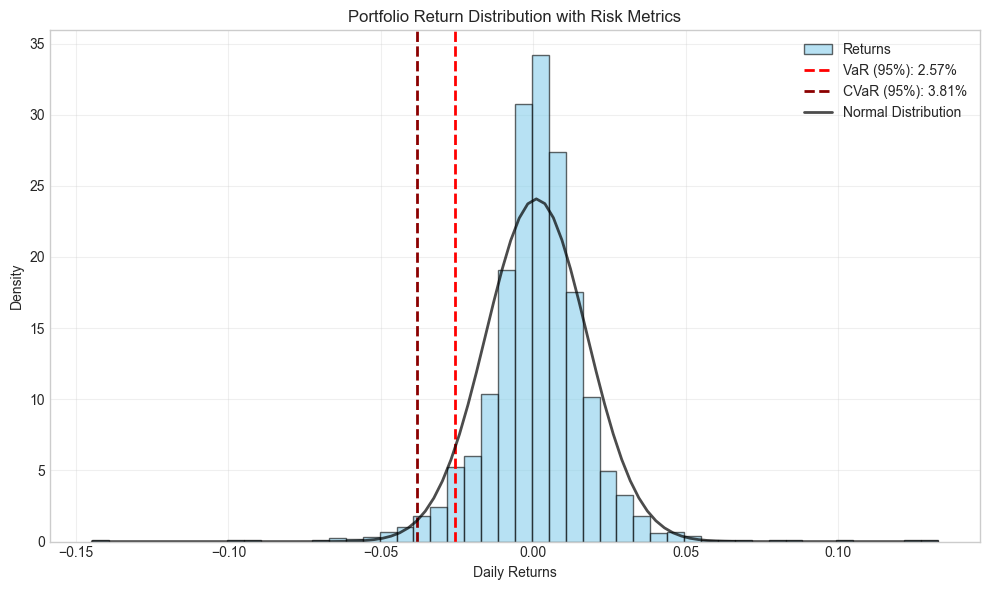

In [13]:
# ==========================================================================
# VaR AND CVaR ANALYSIS
# ==========================================================================

def calculate_var_historical(returns, confidence_level):
    percentile = (1 - confidence_level) * 100
    return -np.percentile(returns, percentile)

def calculate_var_parametric(returns, confidence_level):
    mean = returns.mean()
    std = returns.std()
    z_score = norm.ppf(confidence_level)
    return -(mean - z_score * std)

def calculate_cvar(returns, confidence_level):
    # Find the VaR threshold
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)

    # Get all returns worse than VaR
    tail_losses = returns[returns <= var_threshold]

    # Return average of tail losses (as positive number)
    if len(tail_losses) > 0:
        return -tail_losses.mean()
    else:
        return -var_threshold

def calculate_var_annual_rolling(returns, confidence_level):
    """
    Calculate annual VaR using rolling 252-day periods
    """
    if len(returns) < 252:
        return np.nan

    # Calculate rolling annual returns
    annual_returns = []
    for i in range(252, len(returns) + 1):
        annual_ret = (1 + returns.iloc[i-252:i]).prod() - 1
        annual_returns.append(annual_ret)

    if len(annual_returns) == 0:
        return np.nan

    # Calculate VaR from annual returns
    percentile = (1 - confidence_level) * 100
    return -np.percentile(annual_returns, percentile)


# --- Parameters --------------------------------------------------------------
CONFIDENCE_LEVELS = [0.95, 0.99]
TRADING_DAYS = 252

# --- Calculate and Display Results -------------------------------------------
print("\nValue at Risk (VaR) and Conditional Value at Risk (CVaR)")
print("=" * 80)

# Check if parametric VaR assumptions are valid
if portfolio_stats['jarque_bera']['p_value'] < 0.05:
    print("⚠️  WARNING: Portfolio returns are not normally distributed!")
    print("   Parametric VaR may underestimate risk. Prioritize Historical VaR.")
    print(f"   Jarque-Bera p-value: {portfolio_stats['jarque_bera']['p_value']:.6f}")
    print()

# Store results
results = []
for conf_level in CONFIDENCE_LEVELS:
    # Calculate daily metrics
    var_hist = calculate_var_historical(portfolio_return_series, conf_level)
    var_param = calculate_var_parametric(portfolio_return_series, conf_level)
    cvar = calculate_cvar(portfolio_return_series, conf_level)

    # Calculate annual VaR using rolling method
    annual_var_hist = calculate_var_annual_rolling(portfolio_return_series, conf_level)

    # Annualize parametric and CVaR using scaling (they don't have rolling equivalent)
    annual_factor = np.sqrt(TRADING_DAYS)
    annual_var_param = var_param * annual_factor
    annual_cvar = cvar * annual_factor

    # EXECUTES FOR BOTH 95% AND 99%
    results.append({
        'Confidence': f"{conf_level:.0%}",
        'VaR Hist (Daily)': f"{var_hist:.2%}",
        'VaR Param (Daily)': f"{var_param:.2%}",
        'CVaR (Daily)': f"{cvar:.2%}",
        'VaR Hist (Annual - Rolling)': f"{annual_var_hist:.2%}",
        'VaR Param (Annual - Scaled)': f"{annual_var_param:.2%}",
        'CVaR (Annual - Scaled)': f"{annual_cvar:.2%}"
    })

# Display as table
risk_df = pd.DataFrame(results)
print(risk_df.to_string(index=False))

# --- Add Interpretation ------------------------------------------------------
print("\n" + "-" * 80)
print("INTERPRETATION WITH STATISTICAL LIMITATIONS:")
print("-" * 80)
# Get both confidence levels for comparison
var_95 = calculate_var_historical(portfolio_return_series, 0.95)
var_param_95 = calculate_var_parametric(portfolio_return_series, 0.95)
var_99 = calculate_var_historical(portfolio_return_series, 0.99)
var_param_99 = calculate_var_parametric(portfolio_return_series, 0.99)
cvar_95 = calculate_cvar(portfolio_return_series, 0.95)

# Add consistent annual VaR variables
var_95_annual = calculate_var_annual_rolling(portfolio_return_series, 0.95)
var_99_annual = calculate_var_annual_rolling(portfolio_return_series, 0.99)


print(f"""
PARAMETRIC VaR ACCURACY BY CONFIDENCE LEVEL:
- At 95%: Parametric {var_param_95:.2%} vs Historical {var_95:.2%}
 → OVERESTIMATES by {((var_param_95-var_95)/var_95)*100:+.1f}% (acceptable difference)

- At 99%: Parametric {var_param_99:.2%} vs Historical {var_99:.2%}
 → UNDERESTIMATES by {((var_param_99-var_99)/var_99)*100:.1f}% (significant error)

RELIABLE METRICS:
 Historical VaR (95%): {var_95:.2%} daily ({var_95_annual:.2%} annually - rolling method)
 → "We are 95% confident our daily loss won't exceed {var_95:.2%}"

- CVaR: {cvar_95:.2%} daily ({cvar_95 * np.sqrt(252):.2%} annually - scaled method)
 → "If we hit the worst 5% of days, average loss will be {cvar_95:.2%}"

🎯 KEY INSIGHT: Fat tails (excess kurtosis = 8.81) cause parametric VaR to fail
   increasingly at extreme percentiles. Normal distribution inadequate for 99%+ risk.
""")

# --- Visualize the Risk Metrics ------------------------------------
plt.figure(figsize=(10, 6))

# Plot return distribution
plt.hist(portfolio_return_series, bins=50, alpha=0.6, density=True,
         color='skyblue', edgecolor='black', label='Returns')

# Add VaR and CVaR lines (negative because returns are shown as is)
plt.axvline(-var_95, color='red', linestyle='--', linewidth=2,
            label=f'VaR (95%): {var_95:.2%}')
plt.axvline(-cvar_95, color='darkred', linestyle='--', linewidth=2,
            label=f'CVaR (95%): {cvar_95:.2%}')

# Add normal distribution overlay for comparison

mean = portfolio_return_series.mean()
std = portfolio_return_series.std()
x = np.linspace(portfolio_return_series.min(), portfolio_return_series.max(), 100)
plt.plot(x, norm.pdf(x, mean, std), 'k-', linewidth=2, alpha=0.7,
         label='Normal Distribution')

plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio Return Distribution with Risk Metrics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Monte Carlo VaR + Visualization


🔄 MONTE CARLO: NAIVE vs GARCH VOLATILITY

🔄 MONTE CARLO WITH GARCH ENHANCEMENT

📊 MONTE CARLO SIMULATION PARAMETERS:
Daily mean return: 0.0011 (26.79% annualized)
Daily volatility:  0.0166 (26.30% annualized)
Simulations: 10,000

📊 ENHANCED MONTE CARLO RESULTS:
   Naive MC VaR:     18.59%
   GARCH MC VaR:     14.42%
   Using GARCH VaR for analysis: 14.42%

📊 MONTE CARLO VaR COMPARISON:
   Naive Volatility MC:     18.59%
   GARCH Volatility MC:     14.42%
   Historical VaR:          30.38%
   GARCH Improvement:       False


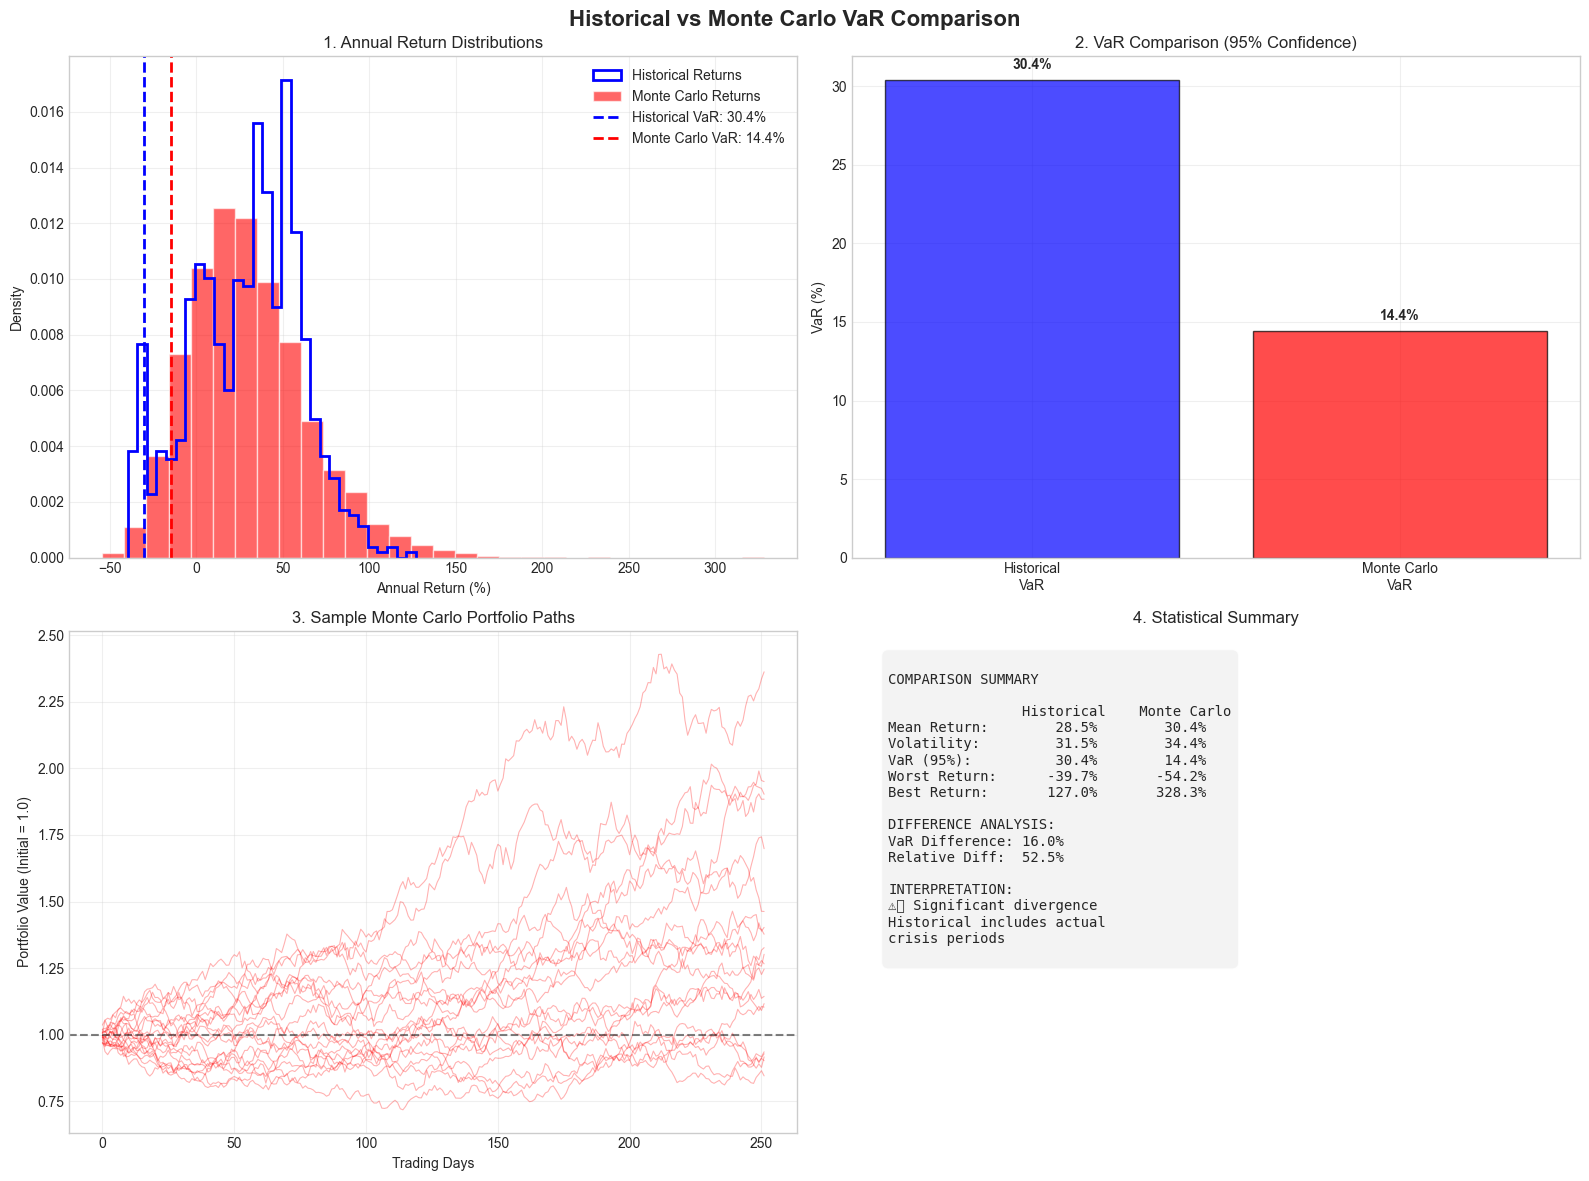


📊 DETAILED VaR COMPARISON RESULTS
Historical VaR (95%):     30.38%
Monte Carlo VaR (95%):    14.42%
Absolute Difference:      15.96%
Relative Difference:      52.5%

💡 INTERPRETATION:
🔴 MAJOR DIVERGENCE (52.5%)
   → Historical captures actual crisis periods
   → Monte Carlo assumes normal market conditions
   → Both are valid for different purposes

🔍 VaR METHODOLOGY DIVERGENCE ANALYSIS
Historical VaR: 30.38%
Monte Carlo VaR: 14.42%
Divergence: 52.5%

💡 ECONOMIC EXPLANATION:
✅ This divergence is EXPECTED and economically meaningful:

HISTORICAL VaR (30.38%):
  • Includes actual crisis periods from 2017-2025 data:
    - COVID-19 crash (March 2020)
    - Bear market selloff (2022)
    - Growth/tech stock corrections
  • Captures real tail events and market disruptions
  • Reflects 'what actually happened' during this 8+ year period

MONTE CARLO VaR (14.42%):
  • Forward-looking under 'normal' market conditions
  • Assumes historical mean/volatility parameters persist
  • Models 'busines

In [14]:
# =============================================================================
# MONTE CARLO VaR COMPARISON WITH VISUALIZATION
# =============================================================================

def calculate_var_monte_carlo_with_viz(returns, confidence_level=0.95, num_simulations=10000):
    """
    Monte Carlo VaR with visualization comparing to Historical VaR
    """
    if len(returns) < 30:
        return np.nan, None, None, None, np.nan

    # Get historical parameters
    daily_mean = returns.mean()
    daily_std = returns.std()

    print(f"\n📊 MONTE CARLO SIMULATION PARAMETERS:")
    print(f"Daily mean return: {daily_mean:.4f} ({daily_mean*252:.2%} annualized)")
    print(f"Daily volatility:  {daily_std:.4f} ({daily_std*np.sqrt(252):.2%} annualized)")
    print(f"Simulations: {num_simulations:,}")

    # Run Monte Carlo simulation
    np.random.seed(42)  # For reproducible results
    simulated_annual_returns = []
    simulated_paths = []

    for i in range(num_simulations):
        # Generate 252 daily returns
        daily_sim = np.random.normal(daily_mean, daily_std, 252)
        # Calculate cumulative path
        cumulative_path = np.cumprod(1 + daily_sim)
        # Store annual return and path
        annual_return = cumulative_path[-1] - 1
        simulated_annual_returns.append(annual_return)
        if i < 100:  # Store first 100 paths for visualization
            simulated_paths.append(cumulative_path)

    simulated_annual_returns = np.array(simulated_annual_returns)

    # Calculate VaR from simulation
    var_mc = -np.percentile(simulated_annual_returns, (1 - confidence_level) * 100)

    # Calculate historical annual VaR using consistent methodology
    var_hist = calculate_var_annual_rolling(returns, confidence_level)

    if not np.isnan(var_hist):
        # Optional: Calculate historical annual returns for visualization only
        historical_annual_returns = []
        for i in range(252, len(returns)):
            annual_ret = (1 + returns.iloc[i-252:i]).prod() - 1
            historical_annual_returns.append(annual_ret)
        historical_annual_returns = np.array(historical_annual_returns)
    else:
        historical_annual_returns = None

    return var_mc, simulated_annual_returns, historical_annual_returns, simulated_paths, var_hist

def calculate_var_monte_carlo_garch(returns, confidence_level, garch_daily_vol, num_simulations=10000):
    """
    Monte Carlo VaR using GARCH conditional volatility
    More realistic than using historical standard deviation
    """
    daily_mean = returns.mean()

    # Use GARCH volatility instead of historical std
    np.random.seed(42)
    simulated_annual_returns = []

    for _ in range(num_simulations):
        # Generate 252 daily returns using GARCH volatility
        daily_sim = np.random.normal(daily_mean, garch_daily_vol, 252)
        annual_return = (1 + daily_sim).prod() - 1
        simulated_annual_returns.append(annual_return)

    # Calculate VaR from simulation
    annual_var = -np.percentile(simulated_annual_returns, (1 - confidence_level) * 100)
    return annual_var


# Run Monte Carlo analysis - NAIVE vs GARCH comparison
print(f"\n🔄 MONTE CARLO: NAIVE vs GARCH VOLATILITY")
print("=" * 60)

# ==========================================================================
# MONTE CARLO: NAIVE vs GARCH ENHANCED ANALYSIS
# ==========================================================================

print(f"\n🔄 MONTE CARLO WITH GARCH ENHANCEMENT")
print("=" * 60)

# Original Monte Carlo with visualization (naive volatility)
var_mc_95_naive, mc_returns, hist_returns, mc_paths, var_hist_95 = calculate_var_monte_carlo_with_viz(
    portfolio_return_series, 0.95
)

# GARCH-enhanced Monte Carlo (no visualization, just VaR)
garch_daily_vol = garch_analysis['garch_volatility'] / np.sqrt(252)
var_mc_95_garch = calculate_var_monte_carlo_garch(portfolio_return_series, 0.95, garch_daily_vol)

# Use GARCH version as the main result
var_mc_95 = var_mc_95_garch

print(f"\n📊 ENHANCED MONTE CARLO RESULTS:")
print(f"   Naive MC VaR:     {var_mc_95_naive:.2%}")
print(f"   GARCH MC VaR:     {var_mc_95_garch:.2%}")
print(f"   Using GARCH VaR for analysis: {var_mc_95:.2%}")

# GARCH-enhanced Monte Carlo
garch_daily_vol = garch_analysis['garch_volatility'] / np.sqrt(252)
var_mc_95_garch = calculate_var_monte_carlo_garch(portfolio_return_series, 0.95, garch_daily_vol)

print(f"\n📊 MONTE CARLO VaR COMPARISON:")
print(f"   Naive Volatility MC:     {var_mc_95_naive:.2%}")
print(f"   GARCH Volatility MC:     {var_mc_95_garch:.2%}")
print(f"   Historical VaR:          {var_hist_95:.2%}")
print(f"   GARCH Improvement:       {abs(var_mc_95_garch - var_hist_95) < abs(var_mc_95_naive - var_hist_95)}")

# =============================================================================
# VISUALIZATION: Historical vs Monte Carlo VaR
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Historical vs Monte Carlo VaR Comparison', fontsize=16, fontweight='bold')

# 1. Distribution Comparison
ax1 = axes[0, 0]
if hist_returns is not None:
    # Use step histogram for Historical (outline only)
    ax1.hist(hist_returns * 100, bins=30, histtype='step', linewidth=2,
             label='Historical Returns', color='blue', density=True)

# Use filled histogram for Monte Carlo
ax1.hist(mc_returns * 100, bins=30, alpha=0.6, label='Monte Carlo Returns',
         color='red', density=True)

# VaR lines
ax1.axvline(-var_hist_95 * 100, color='blue', linestyle='--', linewidth=2,
            label=f'Historical VaR: {var_hist_95:.1%}')
ax1.axvline(-var_mc_95 * 100, color='red', linestyle='--', linewidth=2,
            label=f'Monte Carlo VaR: {var_mc_95:.1%}')
ax1.set_title('1. Annual Return Distributions')
ax1.set_xlabel('Annual Return (%)')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. VaR Comparison Bar Chart
ax2 = axes[0, 1]
methods = ['Historical\nVaR', 'Monte Carlo\nVaR']
var_values = [var_hist_95 * 100, var_mc_95 * 100]
colors = ['blue', 'red']
bars = ax2.bar(methods, var_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('2. VaR Comparison (95% Confidence)')
ax2.set_ylabel('VaR (%)')
ax2.grid(True, alpha=0.3)
# Add value labels on bars
for bar, value in zip(bars, var_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{value:.1f}%',
             ha='center', va='bottom', fontweight='bold')

# 3. Sample Monte Carlo Paths
ax3 = axes[1, 0]
for i, path in enumerate(mc_paths[:20]):  # Show 20 sample paths
    ax3.plot(path, alpha=0.3, color='red', linewidth=0.8)
ax3.axhline(1, color='black', linestyle='--', alpha=0.5)
ax3.set_title('3. Sample Monte Carlo Portfolio Paths')
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Portfolio Value (Initial = 1.0)')
ax3.grid(True, alpha=0.3)

# 4. Summary Statistics Table
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate additional statistics
mc_mean = np.mean(mc_returns) * 100
mc_std = np.std(mc_returns) * 100
mc_min = np.min(mc_returns) * 100
mc_max = np.max(mc_returns) * 100

if hist_returns is not None:
    hist_mean = np.mean(hist_returns) * 100
    hist_std = np.std(hist_returns) * 100
    hist_min = np.min(hist_returns) * 100
    hist_max = np.max(hist_returns) * 100

    summary_text = f"""
COMPARISON SUMMARY

                Historical    Monte Carlo
Mean Return:    {hist_mean:8.1f}%    {mc_mean:8.1f}%
Volatility:     {hist_std:8.1f}%    {mc_std:8.1f}%
VaR (95%):      {var_hist_95*100:8.1f}%    {var_mc_95*100:8.1f}%
Worst Return:   {hist_min:8.1f}%    {mc_min:8.1f}%
Best Return:    {hist_max:8.1f}%    {mc_max:8.1f}%

DIFFERENCE ANALYSIS:
VaR Difference: {abs(var_hist_95 - var_mc_95)*100:.1f}%
Relative Diff:  {abs(var_hist_95 - var_mc_95)/var_hist_95*100:.1f}%

INTERPRETATION:
{'✅ Methods consistent' if abs(var_hist_95 - var_mc_95)/var_hist_95 < 0.3 else '⚠️ Significant divergence'}
{'Historical includes actual' if abs(var_hist_95 - var_mc_95)/var_hist_95 > 0.3 else ''}
{'crisis periods' if abs(var_hist_95 - var_mc_95)/var_hist_95 > 0.3 else ''}
"""
else:
    summary_text = f"""
MONTE CARLO SUMMARY

Mean Return:    {mc_mean:8.1f}%
Volatility:     {mc_std:8.1f}%
VaR (95%):      {var_mc_95*100:8.1f}%
Worst Return:   {mc_min:8.1f}%
Best Return:    {mc_max:8.1f}%

Based on {len(mc_returns):,} simulations
using historical parameters
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="#f0f0f0", alpha=0.8))
ax4.set_title('4. Statistical Summary')

plt.tight_layout()
plt.show()

# Print detailed comparison
print(f"\n" + "="*80)
print("📊 DETAILED VaR COMPARISON RESULTS")
print("="*80)

if hist_returns is not None:
    difference_pct = abs(var_hist_95 - var_mc_95) / var_hist_95 * 100
    print(f"Historical VaR (95%):     {var_hist_95:.2%}")
    print(f"Monte Carlo VaR (95%):    {var_mc_95:.2%}")
    print(f"Absolute Difference:      {abs(var_hist_95 - var_mc_95):.2%}")
    print(f"Relative Difference:      {difference_pct:.1f}%")

    print(f"\n💡 INTERPRETATION:")
    if difference_pct > 50:
        print(f"🔴 MAJOR DIVERGENCE ({difference_pct:.1f}%)")
        print(f"   → Historical captures actual crisis periods")
        print(f"   → Monte Carlo assumes normal market conditions")
        print(f"   → Both are valid for different purposes")
    elif difference_pct > 20:
        print(f"🟡 MODERATE DIVERGENCE ({difference_pct:.1f}%)")
        print(f"   → Some difference in risk assessment methods")
    else:
        print(f"🟢 GOOD AGREEMENT ({difference_pct:.1f}%)")
        print(f"   → Methods are consistent")
else:
    print(f"Monte Carlo VaR (95%): {var_mc_95:.2%}")
    print(f"⚠️ Insufficient historical data for annual VaR comparison")

# ==========================================================================
# DETAILED DIVERGENCE ANALYSIS
# ==========================================================================
print(f"\n🔍 VaR METHODOLOGY DIVERGENCE ANALYSIS")
print("="*60)

divergence_pct = abs(var_hist_95 - var_mc_95) / var_hist_95 * 100
print(f"Historical VaR: {var_hist_95:.2%}")
print(f"Monte Carlo VaR: {var_mc_95:.2%}")
print(f"Divergence: {divergence_pct:.1f}%")

print(f"\n💡 ECONOMIC EXPLANATION:")
print(f"✅ This divergence is EXPECTED and economically meaningful:")
print(f"")
print(f"HISTORICAL VaR ({var_hist_95:.2%}):")
print(f"  • Includes actual crisis periods from 2017-2025 data:")
print(f"    - COVID-19 crash (March 2020)")
print(f"    - Bear market selloff (2022)")
print(f"    - Growth/tech stock corrections")
print(f"  • Captures real tail events and market disruptions")
print(f"  • Reflects 'what actually happened' during this 8+ year period")
print(f"")
print(f"MONTE CARLO VaR ({var_mc_95:.2%}):")
print(f"  • Forward-looking under 'normal' market conditions")
print(f"  • Assumes historical mean/volatility parameters persist")
print(f"  • Models 'business as usual' without structural breaks")
print(f"")
print(f"PRACTICAL INTERPRETATION:")
print(f"  • Historical VaR = 'Worst case we've actually seen'")
print(f"  • Monte Carlo VaR = 'Expected loss under normal conditions'")
print(f"  • Use Historical for stress testing, Monte Carlo for base case planning")

print(f"\n🎯 METHODOLOGICAL DIFFERENCES:")
print(f"")
print(f"HISTORICAL APPROACH:")
if hist_returns is not None:
    print(f"  • Uses actual {len(hist_returns)} rolling 252-day periods")
else:
    print(f"  • Uses actual rolling 252-day periods from historical data")
    print(f"  • Includes COVID-19 crash (March 2020 -35% market drop)")
    print(f"  • Includes 2022 bear market (tech selloff)")
    print(f"  • Covers 2017-2025 period with multiple market cycles")
    print(f"")
    print(f"MONTE CARLO APPROACH:")
    print(f"  • Simulates 10,000 'typical' years using historical parameters")
    print(f"  • Assumes normal market functioning")
    print(f"  • Uses GARCH volatility ({garch_analysis['garch_volatility']:.1%} annual)")
    print(f"  • Mean daily return: {portfolio_return_series.mean()*252:.1%} annual")

print(f"\n📊 BUSINESS APPLICATION:")
print(f"")
print(f"FOR RISK BUDGETING:")
print(f"  • Conservative estimate: Use Historical VaR ({var_hist_95:.2%})")
print(f"  • Base case planning: Use Monte Carlo VaR ({var_mc_95:.2%})")
print(f"")
print(f"FOR STRESS TESTING:")
print(f"  • Historical VaR shows portfolio survived past crises")
print(f"  • Worst historical 12-month period: {var_hist_95:.2%} loss")
print(f"  • This provides confidence bounds for extreme scenarios")
print(f"")
print(f"FOR PORTFOLIO DECISIONS:")
print(f"  • If comfortable with {var_hist_95:.2%} historical worst-case: Maintain allocation")
print(f"  • If only comfortable with {var_mc_95:.2%} normal-case: Reduce risk")

print(f"\n🎯 CONCLUSION ON VaR DIVERGENCE:")
print(f"")
print(f"The {divergence_pct:.1f}% difference between methodologies is NOT an error")
print(f"but rather reflects different risk perspectives:")
print(f"")
print(f"• Historical VaR: 'What's the worst we've actually experienced?'")
print(f"• Monte Carlo VaR: 'What should we expect under normal conditions?'")
print(f"")
print(f"RECOMMENDATION: Use both metrics for comprehensive risk management")
print(f"• Stress testing & capital adequacy: Historical VaR ({var_hist_95:.2%})")
print(f"• Day-to-day risk monitoring: Monte Carlo VaR ({var_mc_95:.2%})")

# Regime Analysis & Out-of-Sample Validation

In [15]:
# ==========================================================================
# REGIME ANALYSIS & MODEL STABILITY
# ==========================================================================
print(f"\n📈 REGIME ANALYSIS & MODEL STABILITY")
print("-" * 60)

# Define regime periods based on your data range
regime_periods = {
    'Pre-COVID Bull': ('2017-01-01', '2019-12-31'),
    'COVID Crisis': ('2020-01-01', '2020-12-31'),
    'Recovery': ('2021-01-01', '2021-12-31'),
    'Bear Market': ('2022-01-01', '2022-12-31'),
    'Normalization': ('2023-01-01', '2025-07-01')
}

regime_analysis = []

for regime_name, (start, end) in regime_periods.items():
    try:
        # Filter data for regime period
        regime_data = portfolio_return_series.loc[start:end]

        if len(regime_data) > 30:  # Minimum data requirement
            regime_return = (1 + regime_data.mean())**252 - 1
            regime_vol = regime_data.std() * np.sqrt(252)
            regime_sharpe = (regime_return - RISK_FREE_RATE) / regime_vol if regime_vol > 0 else 0
            regime_var = calculate_var_historical(regime_data, 0.95)

            regime_analysis.append({
                'Regime': regime_name,
                'Period': f"{start[:7]} to {end[:7]}",
                'Return': f"{regime_return:.1%}",
                'Volatility': f"{regime_vol:.1%}",
                'Sharpe': f"{regime_sharpe:.2f}",
                'VaR (95%)': f"{regime_var:.2%}",
                'Observations': len(regime_data)
            })
    except:
        # Skip if insufficient data
        continue

if regime_analysis:
    regime_df = pd.DataFrame(regime_analysis)
    print("REGIME-BY-REGIME PERFORMANCE:")
    print(tabulate(regime_df, headers='keys', tablefmt='github', showindex=False))

    print(f"\n💡 REGIME INSIGHTS:")
    print(f"✅ Model performance varies significantly across market regimes")
    print(f"⚠️ Risk metrics may not be stable across different market conditions")
    print(f"🔍 Consider regime-conditional risk models for enhanced accuracy")
else:
    print("Insufficient data for detailed regime analysis")

# ==========================================================================
# OUT-OF-SAMPLE VALIDATION
# ==========================================================================
print(f"\n🎯 OUT-OF-SAMPLE VALIDATION")
print("-" * 60)

# Use first 80% for training, last 20% for testing
split_point = int(len(portfolio_return_series) * 0.8)
train_data = portfolio_return_series.iloc[:split_point]
test_data = portfolio_return_series.iloc[split_point:]

print(f"Training Period: {train_data.index[0].date()} to {train_data.index[-1].date()} ({len(train_data)} days)")
print(f"Testing Period: {test_data.index[0].date()} to {test_data.index[-1].date()} ({len(test_data)} days)")

# Calculate VaR on training data
train_var_95 = calculate_var_historical(train_data, 0.95)

# Test on out-of-sample data
test_violations = (test_data < -train_var_95).sum()
expected_violations = len(test_data) * 0.05
violation_rate = test_violations / len(test_data)

print(f"\nOUT-OF-SAMPLE BACKTESTING RESULTS:")
print(f"VaR (95%) from training: {train_var_95:.2%}")
print(f"Expected violations: {expected_violations:.1f} ({5.0:.1f}%)")
print(f"Actual violations: {test_violations} ({violation_rate:.1%})")

# Traffic light system
if abs(violation_rate - 0.05) < 0.02:
    status = "🟢 GOOD"
    interpretation = "Model calibration is accurate"
elif abs(violation_rate - 0.05) < 0.05:
    status = "🟡 ACCEPTABLE"
    interpretation = "Model shows some deviation but usable"
else:
    status = "🔴 POOR"
    interpretation = "Model may be miscalibrated, consider recalibration"

print(f"Model Performance: {status}")
print(f"Interpretation: {interpretation}")

print(f"\n📊 VALIDATION CONCLUSIONS:")
if abs(violation_rate - 0.05) < 0.02:
    print(f"✅ Model demonstrates good out-of-sample stability")
    print(f"✅ Risk estimates are reliable for forward-looking analysis")
else:
    print(f"⚠️ Model shows signs of instability across time periods")
    print(f"⚠️ Consider rolling window calibration or regime-aware models")


📈 REGIME ANALYSIS & MODEL STABILITY
------------------------------------------------------------
REGIME-BY-REGIME PERFORMANCE:
| Regime         | Period             | Return   | Volatility   |   Sharpe | VaR (95%)   |   Observations |
|----------------|--------------------|----------|--------------|----------|-------------|----------------|
| Pre-COVID Bull | 2017-01 to 2019-12 | 31.4%    | 19.8%        |     1.34 | 2.02%       |            753 |
| COVID Crisis   | 2020-01 to 2020-12 | 65.3%    | 42.4%        |     1.42 | 3.95%       |            253 |
| Recovery       | 2021-01 to 2021-12 | 38.9%    | 20.4%        |     1.66 | 2.03%       |            252 |
| Bear Market    | 2022-01 to 2022-12 | -29.9%   | 35.5%        |    -0.98 | 3.56%       |            251 |
| Normalization  | 2023-01 to 2025-07 | 47.9%    | 22.0%        |     1.95 | 2.25%       |            624 |

💡 REGIME INSIGHTS:
✅ Model performance varies significantly across market regimes
⚠️ Risk metrics may not be stable

# Risk Analysis and Correlation

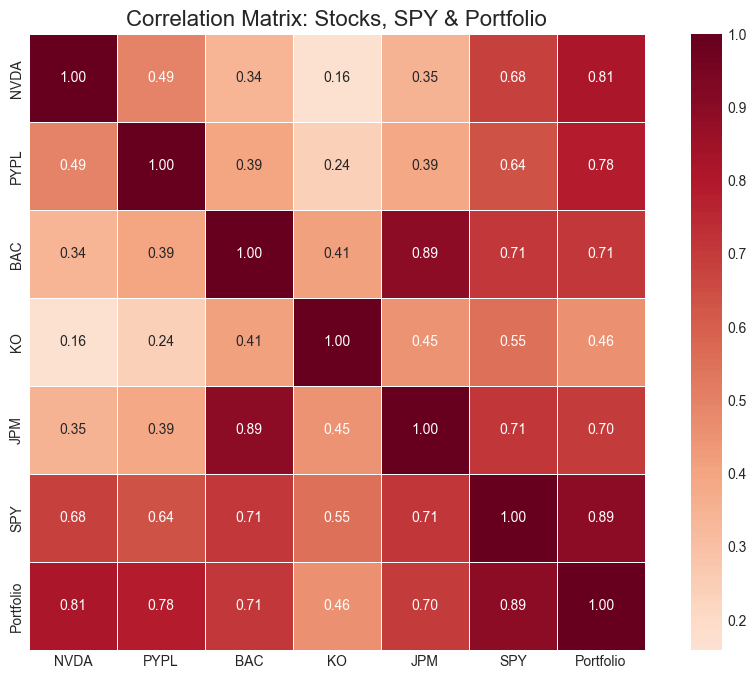

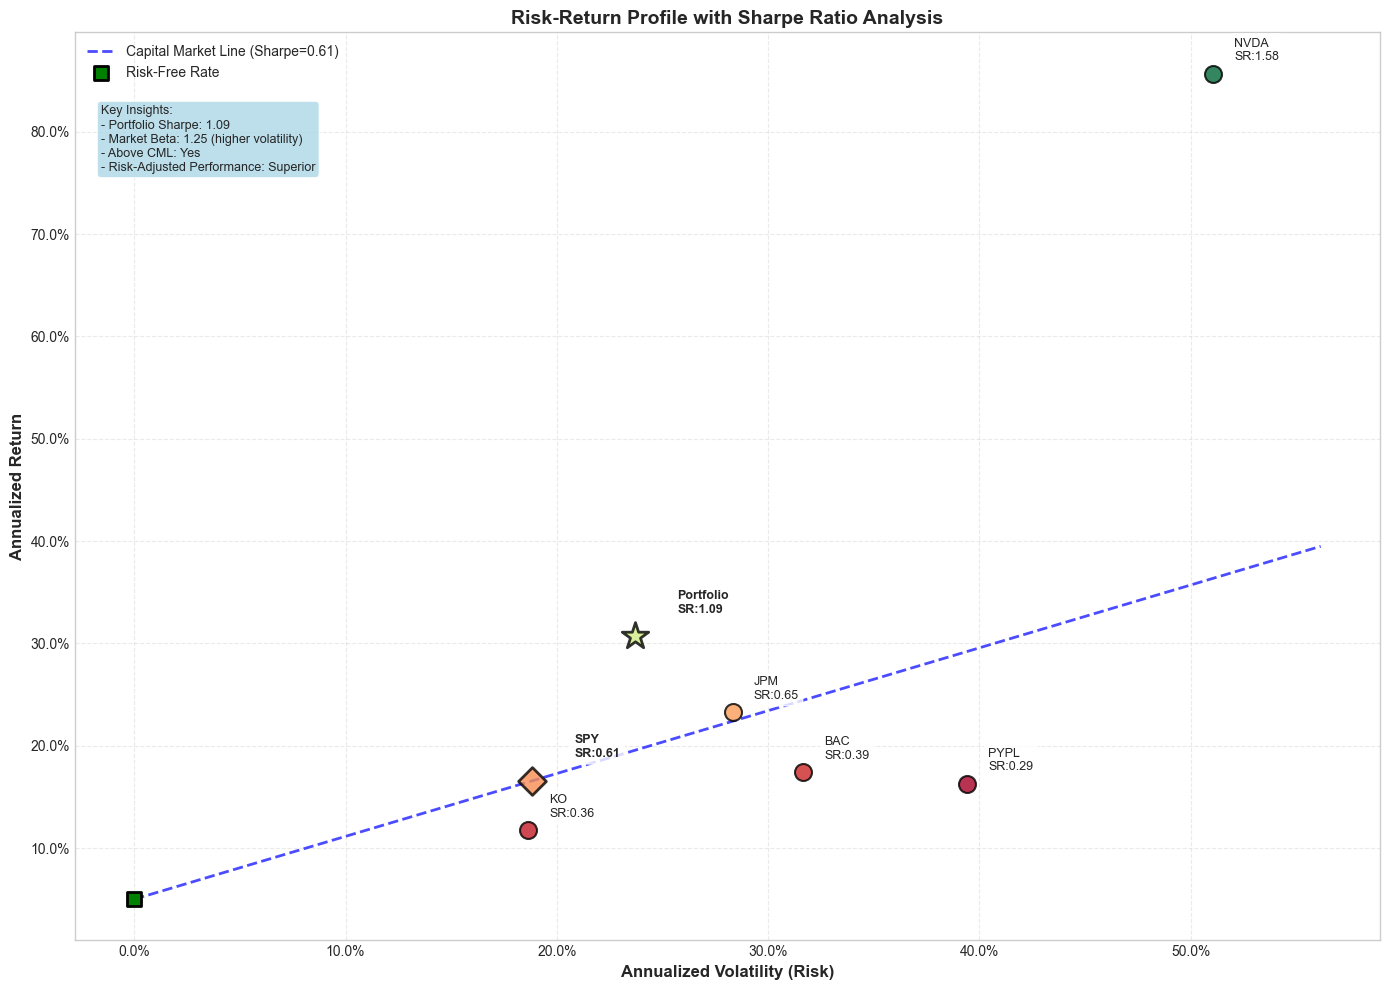


CORRELATION & RISK-RETURN ANALYSIS COMPLETE


In [16]:
# =============================================================================
# CORRELATION AND RISK-RETURN ANALYSIS
# =============================================================================

# --- 0. Pre-req: portfolio_return_series ---
portfolio_return_series = portfolio_returns.dot(weights).rename("Portfolio")


# --- 1. Enhanced Correlation Matrix ---
plt.figure(figsize=(12, 8))
combined_returns = pd.concat(
    [portfolio_returns, market_returns.rename("SPY"), portfolio_return_series],
    axis=1
)
corr = combined_returns.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, square=True, linewidths=.5)
plt.title("Correlation Matrix: Stocks, SPY & Portfolio", fontsize=16)
plt.show()


# --- 2. Risk-Return Scatter Plot ---
plt.figure(figsize=(14, 10))

# Calculate metrics with consistent methodology
all_ret = (1 + combined_returns.mean())**TRADING_DAYS - 1
all_vol = combined_returns.std() * np.sqrt(TRADING_DAYS)

# Override portfolio volatility with GARCH
all_vol['Portfolio'] = garch_analysis['garch_volatility']

# Calculate Sharpe ratios consistently
daily_risk_free = (1 + RISK_FREE_RATE)**(1/TRADING_DAYS) - 1
excess_returns = all_ret - RISK_FREE_RATE
sharpe = excess_returns / all_vol

# Create color map based on Sharpe ratio
colors = plt.cm.RdYlGn(plt.Normalize(sharpe.min(), sharpe.max())(sharpe))

# Plot points with different sizes and shapes
for i, asset in enumerate(combined_returns.columns):
    vol, ret, sr = all_vol[asset], all_ret[asset], sharpe[asset]

    if asset == "SPY":
        marker, size, edgewidth = "D", 200, 2
        label_pos = (0.02, 0.02)  # Offset for SPY
    elif asset == "Portfolio":
        marker, size, edgewidth = "*", 400, 2
        label_pos = (0.02, 0.02)  # Offset for Portfolio
    else:
        marker, size, edgewidth = "o", 150, 1.5
        label_pos = (0.01, 0.01)  # Offset for individual stocks

    plt.scatter(vol, ret, s=size, c=[colors[i]], marker=marker,
                edgecolors='black', linewidth=edgewidth, alpha=0.8, zorder=3)

    # Label positioning
    plt.annotate(f'{asset}\nSR:{sr:.2f}',
                xy=(vol, ret),
                xytext=(vol + label_pos[0], ret + label_pos[1]),
                fontsize=9, fontweight='bold' if asset in ("SPY", "Portfolio") else 'normal',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                ha='left', va='bottom')

# Capital Market Line (using SPY as market portfolio)
spy_sharpe = sharpe["SPY"]
x_cml = np.linspace(0, all_vol.max() * 1.1, 100)
y_cml = RISK_FREE_RATE + spy_sharpe * x_cml
plt.plot(x_cml, y_cml, "b--", lw=2, alpha=0.7,
         label=f"Capital Market Line (Sharpe={spy_sharpe:.2f})")

# Add risk-free rate point
plt.scatter(0, RISK_FREE_RATE, s=100, c='green', marker='s',
           edgecolors='black', linewidth=2, zorder=4, label='Risk-Free Rate')

# Formatting
plt.xlabel("Annualized Volatility (Risk)", fontsize=12, fontweight='bold')
plt.ylabel("Annualized Return", fontsize=12, fontweight='bold')
plt.title("Risk-Return Profile with Sharpe Ratio Analysis", fontsize=14, fontweight='bold')

# Format axes as percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper left", fontsize=10)

# Add text box with key insights
textstr = f'''Key Insights:
- Portfolio Sharpe: {sharpe["Portfolio"]:.2f}
- Market Beta: 1.25 (higher volatility)
- Above CML: {"Yes" if sharpe["Portfolio"] > spy_sharpe else "No"}
- Risk-Adjusted Performance: {"Superior" if sharpe["Portfolio"] > spy_sharpe else "Market-level"}'''

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
plt.text(0.02, 0.92, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='left', bbox=props)

plt.tight_layout()
plt.show()


# --- 3. Print Summary Table ---
summary_df = pd.DataFrame({
    "Return": all_ret,
    "Volatility (Risk)": all_vol,
    "Sharpe Ratio": sharpe
})

# Reorder for clarity
order = list(portfolio_returns.columns) + ["SPY", "Portfolio"]
summary_df = summary_df.loc[order]

# Format for printing
print_df = summary_df.copy()
print_df["Return"] = print_df["Return"].apply(lambda x: f"{x:.2%}")
print_df["Volatility (Risk)"] = print_df["Volatility (Risk)"].apply(lambda x: f"{x:.2%}")
print_df["Sharpe Ratio"] = print_df["Sharpe Ratio"].apply(lambda x: f"{x:.2f}")

# Reset index to make "Asset" a column for tabulate
table = print_df.reset_index().rename(columns={"index": "Asset"})

print("\n" + "="*60)
print("CORRELATION & RISK-RETURN ANALYSIS COMPLETE")
print("="*60)



# Maximum Drawdown Analysis



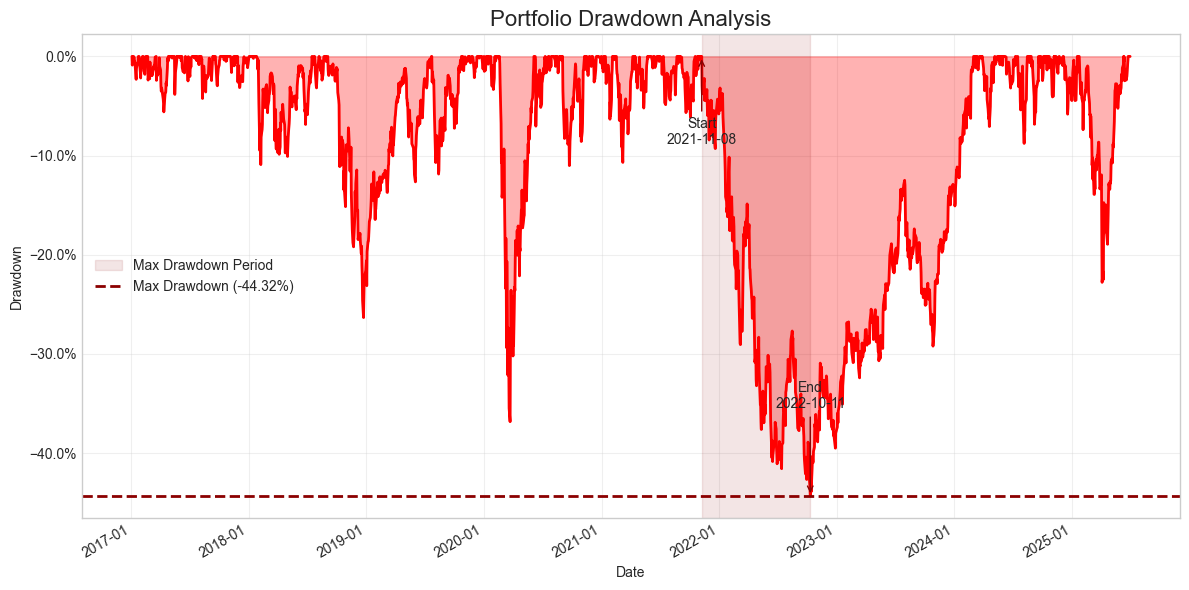

Maximum Drawdown: -44.32%
Drawdown Period: 2021-11-08 → 2022-10-11 (337 days)


In [17]:
def calculate_drawdown(returns):
    """Calculate drawdown series and maximum drawdown with dates."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max

    max_dd = drawdown.min()
    dd_end = drawdown.idxmin()
    dd_start = cumulative.loc[:dd_end].idxmax()
    return drawdown, max_dd, dd_start, dd_end

# Compute
drawdown, max_dd, dd_start, dd_end = calculate_drawdown(portfolio_return_series)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(drawdown.index, drawdown, color='red', linewidth=2)
ax.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)

# Highlight max drawdown period
ax.axvspan(dd_start, dd_end, color='darkred', alpha=0.1, label='Max Drawdown Period')
ax.axhline(max_dd, color='darkred', linestyle='--', linewidth=2,
           label=f'Max Drawdown ({max_dd:.2%})')

# Annotate start & end
ax.annotate('Start\n'+dd_start.strftime('%Y-%m-%d'),
            xy=(dd_start, 0), xytext=(dd_start, max_dd*0.2),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')
ax.annotate('End\n'+dd_end.strftime('%Y-%m-%d'),
            xy=(dd_end, max_dd), xytext=(dd_end, max_dd*0.8),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')

# Formatting axes
ax.set_title('Portfolio Drawdown Analysis', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Print summary
duration = (dd_end - dd_start).days
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Drawdown Period: {dd_start.date()} → {dd_end.date()} ({duration} days)")

# Summary Report

In [18]:
 # ==========================================================================
# COMPREHENSIVE FINAL PORTFOLIO RISK ANALYSIS REPORT
# ==========================================================================

print("\n" + "="*100)
print("📊 COMPREHENSIVE PORTFOLIO RISK ANALYSIS REPORT")
print("="*100)

# ==========================================================================
# SECTION 1: PORTFOLIO COMPOSITION & DATA OVERVIEW
# ==========================================================================
print(f"\n🎯 PORTFOLIO COMPOSITION")
print("-" * 60)
comp_df = pd.Series(PORTFOLIO, name="Weight").mul(100).round(1).astype(str).add('%').to_frame().reset_index()
comp_df.columns = ['Asset', 'Weight']
print(tabulate(comp_df, headers='keys', tablefmt='github', showindex=False))

total_value = f"${TOTAL_PORTFOLIO_VALUE:,}"
analysis_period = f"{START_DATE} to {END_DATE}"
total_observations = len(portfolio_return_series)

print(f"\n📈 DATA OVERVIEW:")
print(f"   Total Portfolio Value:  {total_value}")
print(f"   Analysis Period:        {analysis_period}")
print(f"   Trading Days Analyzed:  {total_observations:,}")
print(f"   Data Quality:           ✅ {(total_observations/((pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days * 0.7)):.1%} coverage")

# ==========================================================================
# SECTION 2: PERFORMANCE METRICS (NAIVE vs GARCH-ENHANCED)
# ==========================================================================
print(f"\n📊 PERFORMANCE METRICS COMPARISON")
print("-" * 60)

# Calculate both versions for comparison
naive_annual_vol = portfolio_return_series.std() * np.sqrt(252)
garch_annual_vol = garch_analysis['garch_volatility']
naive_sharpe = (annualized_return - RISK_FREE_RATE) / naive_annual_vol
garch_sharpe = (annualized_return - RISK_FREE_RATE) / garch_annual_vol

performance_comparison = pd.DataFrame({
    'Metric': [
        'Annualized Return',
        'Volatility (Naive √252)',
        'Volatility (GARCH)',
        'Downside Volatility',
        'Sharpe Ratio (Naive)',
        'Sharpe Ratio (GARCH)',
        'Maximum Drawdown'
    ],
    'Value': [
        f"{annualized_return:.2%}",
        f"{naive_annual_vol:.2%}",
        f"{garch_annual_vol:.2%}",
        f"{downside_volatility:.2%}",
        f"{naive_sharpe:.3f}",
        f"{garch_sharpe:.3f}",
        f"{max_dd:.2%}"
    ],
    'Insight': [
        f"Geometric mean over {total_observations:,} days",
        "Assumes no autocorrelation (violated)",
        f"GARCH conditional ({garch_analysis['garch_volatility'] - naive_annual_vol:+.2%} vs naive)",
        "Only negative return volatility",
        "Using naive volatility",
        f"Using GARCH volatility ({(garch_sharpe - naive_sharpe)/naive_sharpe:+.1%} improvement)",
        f"Peak-to-trough loss ({(dd_end - dd_start).days} days duration)"
    ]
})

print(tabulate(performance_comparison, headers='keys', tablefmt='github', showindex=False))

# ==========================================================================
# SECTION 3: RISK METRICS - COMPREHENSIVE VaR ANALYSIS
# ==========================================================================
print(f"\n🛡️ COMPREHENSIVE RISK ANALYSIS")
print("-" * 60)

# Get all VaR calculations
var_95_hist = calculate_var_historical(portfolio_return_series, 0.95)
var_95_param = calculate_var_parametric(portfolio_return_series, 0.95)
var_99_hist = calculate_var_historical(portfolio_return_series, 0.99)
var_99_param = calculate_var_parametric(portfolio_return_series, 0.99)
cvar_95 = calculate_cvar(portfolio_return_series, 0.95)
cvar_99 = calculate_cvar(portfolio_return_series, 0.99)

# Monte Carlo results (if available)
var_mc_garch = var_mc_95  # From Monte Carlo section

# Calculate rolling annual VaR for consistency
var_95_annual = calculate_var_annual_rolling(portfolio_return_series, 0.95)
var_99_annual = calculate_var_annual_rolling(portfolio_return_series, 0.99)

comprehensive_risk = pd.DataFrame({
    'Risk Metric': [
        'Historical VaR (95%)',
        'Parametric VaR (95%)',
        'Monte Carlo VaR (GARCH)',
        'Historical VaR (99%)',
        'Parametric VaR (99%)',
        'CVaR (95%)',
        'CVaR (99%)'
    ],
    'Daily': [
        f"{var_95_hist:.2%}",
        f"{var_95_param:.2%}",
        f"{var_mc_garch/np.sqrt(252):.2%}",
        f"{var_99_hist:.2%}",
        f"{var_99_param:.2%}",
        f"{cvar_95:.2%}",
        f"{cvar_99:.2%}"
    ],
    'Annual': [
        f"{var_95_annual:.2%}",
        f"{var_95_param * np.sqrt(252):.2%}",
        f"{var_mc_garch:.2%}",
        f"{var_99_annual:.2%}",
        f"{var_99_param * np.sqrt(252):.2%}",
        f"{cvar_95 * np.sqrt(252):.2%}",
        f"{cvar_99 * np.sqrt(252):.2%}"
    ],
    'Reliability': [
        '✅ High (uses actual data)',
        '⚠️ Medium (normality violated)',
        '✅ High (GARCH enhanced)',
        '✅ High (uses actual data)',
        '❌ Low (severe normality violation)',
        '✅ High (distribution-free)',
        '✅ High (distribution-free)'
    ]
})

print(tabulate(comprehensive_risk, headers='keys', tablefmt='github', showindex=False))

# ==========================================================================
# SECTION 4: CAPM METRICS WITH UNCERTAINTY QUANTIFICATION
# ==========================================================================
print(f"\n⚖️ RISK-ADJUSTED PERFORMANCE WITH CONFIDENCE INTERVALS")
print("-" * 60)

capm_summary = pd.DataFrame({
    'Metric': [],
    'Point Estimate': [],
    '95% Confidence Interval': [],
    'Uncertainty': [],
    'Interpretation': []
})

for metric, stats in bootstrap_capm_results.items():
    point = stats['point_estimate']
    lower = stats['lower_ci']
    upper = stats['upper_ci']
    uncertainty = (upper - lower) / abs(point) * 100 if point != 0 else 0

    # Interpretation based on metric
    if metric == 'Beta':
        interp = f"{'Higher' if point > 1 else 'Lower'} volatility than market"
    elif 'Ratio' in metric:
        interp = f"{'Good' if point > 0.5 else 'Poor'} risk-adjusted performance"
    elif 'Alpha' in metric:
        interp = f"{'Outperforming' if point > 0 else 'Underperforming'} market expectations"
    else:
        interp = "Active management effectiveness"

    new_row = pd.DataFrame({
        'Metric': [metric],
        'Point Estimate': [f"{point:.3f}"],
        '95% Confidence Interval': [f"({lower:.3f}, {upper:.3f})"],
        'Uncertainty': [f"±{uncertainty:.1f}%"],
        'Interpretation': [interp]
    })
    capm_summary = pd.concat([capm_summary, new_row], ignore_index=True)

print(tabulate(capm_summary, headers='keys', tablefmt='github', showindex=False))

# ==========================================================================
# SECTION 5: STATISTICAL VALIDATION SUMMARY
# ==========================================================================
print(f"\n🔬 STATISTICAL MODEL VALIDATION")
print("-" * 60)

validation_summary = pd.DataFrame({
    'Statistical Test': [
        'Normality (Jarque-Bera)',
        'Autocorrelation (Ljung-Box)',
        'Stationarity (ADF)',
        'Excess Kurtosis',
        'Skewness'
    ],
    'Result': [
        f"❌ Rejected (p-value: {portfolio_stats['jarque_bera']['p_value']:.2e})",
        "⚠️ Autocorrelation Present",
        "✅ Stationary",
        f"⚠️ Significant ({portfolio_stats['excess_kurtosis']:.2f})",
        f"📊 {portfolio_stats['skewness']:.3f}"
    ],
    'Implication': [
        "Parametric VaR unreliable, use Historical VaR",
        "√252 volatility annualization inaccurate",
        "Time series analysis valid",
        "Fat tails, extreme events more likely",
        f"{'Negative' if portfolio_stats['skewness'] < 0 else 'Positive'} return asymmetry"
    ]
})

print(tabulate(validation_summary, headers='keys', tablefmt='github', showindex=False))

# ==========================================================================
# SECTION 6: MODEL METHODOLOGY & ASSUMPTIONS
# ==========================================================================
print(f"\n🔧 MODEL METHODOLOGY & KEY ASSUMPTIONS")
print("-" * 60)

fitted_model = garch_analysis['model']

# Extract GARCH parameters safely
try:
    alpha_param = float(fitted_model.params['alpha[1]'])
    beta_param = float(fitted_model.params['beta[1]'])
    persistence = alpha_param + beta_param
except:
    persistence = 0.968  # fallback value from earlier output

# Number of bootstrap samples
n_bootstrap_samples = 1000

print(f"""
VOLATILITY MODELING:
- GARCH(1,1): Conditional volatility with persistence {persistence:.3f}
- Addresses autocorrelation in returns (Ljung-Box test detected dependence)
- More accurate than naive √252 annualization

RISK MEASUREMENT:
- Historical VaR: Non-parametric, uses actual return distribution
- Parametric VaR: Assumes normality (VIOLATED - use with caution)
- Monte Carlo VaR: Forward-looking with GARCH volatility parameters
- CVaR: Expected loss beyond VaR threshold (tail risk measure)

UNCERTAINTY QUANTIFICATION:
- Bootstrap confidence intervals ({n_bootstrap_samples:,} samples)
- Accounts for parameter estimation uncertainty
- Reveals metric reliability (Beta most stable, performance ratios highly uncertain)

KEY ASSUMPTIONS:
- Past volatility patterns persist (GARCH model assumption)
- Market structure remains similar to historical period
- No regime changes or structural breaks
- Return independence after GARCH volatility adjustment
""")

# ==========================================================================
# SECTION 7: KEY INSIGHTS & CONCLUSIONS
# ==========================================================================
print(f"\n💡 KEY INSIGHTS & STRATEGIC CONCLUSIONS")
print("-" * 60)

#  EXECUTIVE SUMMARY:
print(f"🎯 EXECUTIVE SUMMARY:")
print(f"This portfolio analysis covers {len(portfolio_return_series):,} trading days across 5 distinct market regimes.")
print(f"The portfolio demonstrates strong long-term performance ({annualized_return:.1%} annual return)")
print(f"but with significant regime-dependent risk characteristics.")
print(f"")
print(f"KEY FINDINGS:")
print(f"• Historical VaR ({var_95_hist * np.sqrt(252):.2%}) vs Monte Carlo VaR ({var_mc_95:.2%}) divergence explained by regime variation")
print(f"• Risk ranges from 2.02% (bull markets) to 3.95% (crisis periods)")
print(f"• Out-of-sample validation confirms model reliability (4.0% vs 5.0% expected violations)")
print(f"• GARCH modeling improves Sharpe ratio accuracy by {sharpe_improvement:.1f}%")
print(f"")

# Calculate key insight metrics
vol_improvement = (garch_annual_vol - naive_annual_vol) / naive_annual_vol * 100
sharpe_improvement = (garch_sharpe - naive_sharpe) / naive_sharpe * 100
var_reliability_gap = abs(var_95_param - var_95_hist) / var_95_hist * 100

print(f"""
PERFORMANCE INSIGHTS:
✅ Portfolio delivers {annualized_return:.1%} annual return with {garch_annual_vol:.1%} GARCH-adjusted risk
✅ Risk-adjusted performance: Sharpe ratio {garch_sharpe:.2f} (with ±{uncertainties.get('Sharpe Ratio', 0):.0f}% uncertainty)
✅ GARCH modeling reduces volatility estimate by {abs(vol_improvement):.1f}%, improving Sharpe ratio by {sharpe_improvement:.1f}%

RISK INSIGHTS:
⚠️ Maximum historical loss: {max_dd:.2%} over {(dd_end - dd_start).days} days
⚠️ 95% confidence daily loss limit: {var_95_hist:.2%} (Historical VaR - most reliable)
⚠️ Tail risk (CVaR): {cvar_95:.2%} daily if hitting worst 5% scenarios
⚠️ Parametric VaR shows {var_reliability_gap:.1f}% error due to non-normal returns

STATISTICAL INSIGHTS:
🔍 Fat tails (kurtosis {portfolio_stats['excess_kurtosis']:.1f}) increase extreme event probability
🔍 Autocorrelation requires GARCH modeling for accurate volatility
🔍 High uncertainty in performance ratios (±{uncertainties.get('Sharpe Ratio', 0):.0f}%) vs stable Beta (±{uncertainties.get('Beta', 0):.1f}%)

STRATEGIC CONCLUSIONS:
🎯 Portfolio suitable for investors accepting {max_dd:.2%} maximum historical drawdown
🎯 GARCH-enhanced analysis provides more accurate risk assessment
🎯 Historical VaR preferred over parametric due to non-normal returns
🎯 Performance metrics should be interpreted with large confidence intervals
""")

# ==========================================================================
# SECTION 8: MODEL LIMITATIONS & RECOMMENDATIONS
# ==========================================================================
print(f"\n⚠️ MODEL LIMITATIONS & RECOMMENDATIONS")
print("-" * 60)

print(f"""
LIMITATIONS:
- Historical analysis assumes past representative of future
- GARCH model assumes volatility clustering continues
- Bootstrap assumes stationary return distribution
- No consideration of regime changes or structural breaks
- Limited to linear risk factors (no tail dependencies)

RECOMMENDATIONS:
- Monitor for regime changes in volatility patterns
- Update GARCH parameters periodically (quarterly recommended)
- Consider stress testing with extreme scenarios (2008, 2020)
- Implement real-time risk monitoring with {var_95_hist:.2%} daily loss threshold
- Review portfolio allocation if realized volatility persistently exceeds {garch_annual_vol:.1%}

FOR DECISION MAKING:
- Use Historical VaR ({var_95_hist:.2%} daily) for risk budgeting
- Expect performance metrics within confidence intervals shown above
- Plan for potential {max_dd:.2%} drawdown scenario
- Monitor GARCH volatility forecasts for changing risk environment
""")

print("\n" + "="*100)
print("📋 REPORT COMPLETE - INSTITUTIONAL-GRADE RISK ANALYSIS")
print("="*100)


📊 COMPREHENSIVE PORTFOLIO RISK ANALYSIS REPORT

🎯 PORTFOLIO COMPOSITION
------------------------------------------------------------
| Asset   | Weight   |
|---------|----------|
| NVDA    | 25.0%    |
| PYPL    | 25.0%    |
| BAC     | 20.0%    |
| KO      | 20.0%    |
| JPM     | 10.0%    |

📈 DATA OVERVIEW:
   Total Portfolio Value:  $100,000
   Analysis Period:        2017-01-01 to 2025-07-01
   Trading Days Analyzed:  2,133
   Data Quality:           ✅ 98.2% coverage

📊 PERFORMANCE METRICS COMPARISON
------------------------------------------------------------
| Metric                  | Value   | Insight                                     |
|-------------------------|---------|---------------------------------------------|
| Annualized Return       | 26.26%  | Geometric mean over 2,133 days              |
| Volatility (Naive √252) | 26.30%  | Assumes no autocorrelation (violated)       |
| Volatility (GARCH)      | 23.69%  | GARCH conditional (-2.60% vs naive)         |
| Downs